<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/how_train_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train a dataset
![](https://github.com/ai-fast-track/icevision/blob/fridge-tutorial/images/fridge-objects.png?raw=1)

## Introduction

This tutorial walk you through the different steps of training the fridge dataset. the IceVision Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai2](https://github.com/fastai/fastai2) library.

For more information about how the fridge dataset as well as its corresponding parser check out the [fridge folder](https://github.com/airctic/icevision/tree/master/icevision/datasets/fridge) in IceVision.

## Using Google Colab
First, enable the GPU runtime:  
`Runtime` -> `Change runtime type` -> `Hardware accelerator dropdown` -> `GPU`  

## Packages Installations

In [ ]:
# Installing IceVision
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade
!pip install omegaconf effdet@https://github.com/rwightman/efficientdet-pytorch/archive/master.zip#egg=effdet-0.1.4

## Imports

In [2]:

from icevision.all import *

## Datasets : Fridge Objects dataset
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [ ]:
# Loading Data
data_dir = datasets.fridge.load()

In [ ]:
# Parser
class_map = datasets.fridge.class_map()
parser = datasets.fridge.parser(data_dir, class_map)
data_splitter = RandomSplitter([0.8, 0.2])
train_records, valid_records = parser.parse(data_splitter)

<div class="alert alert-warning">

**Important**

A record is a dictionary that contains all parsed fields defined by the parser used. No matter what format the annotations used, a record has a common structure that can be connected to different DL frameworks (fastai, Pytorch-Lightning, etc.)

</div>

### Visualization
Showing a batch of images with their corresponding boxes and labels

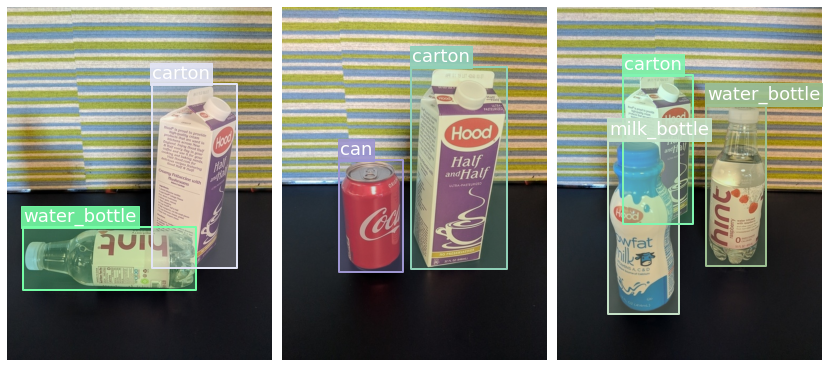

In [5]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## Train and Validation Dataset Transforms

In [6]:
# Transforms
presize = 512
size = 384
train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

## 
Dataset

Not to be confused with our previous `datasets` module, `Dataset` is a class that combines the records and transforms.

For creating a `Dataset` we just need need to pass the parsed records from the previous step and optionally the transforms.


In [7]:
# Create both training and validation datasets - using Albumentations transforms out of the box
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

<div class="alert alert-warning">
What a `Dataset` class  does:  
* Prepares the record: For example, in the record we just have a filename that points to the image, it's at this stage that we open the image. 
* Apply the pipeline of transforms to record processed in the previous step
</div>

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

### Displaying the same image with different transforms

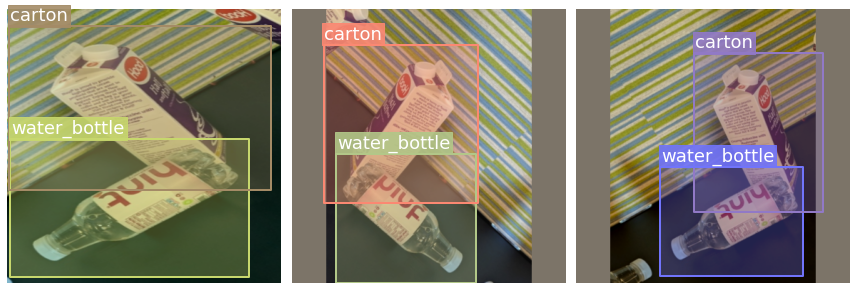

In [8]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map, denormalize_fn=denormalize_imagenet)

## DataLoader

In [9]:
# DataLoaders
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

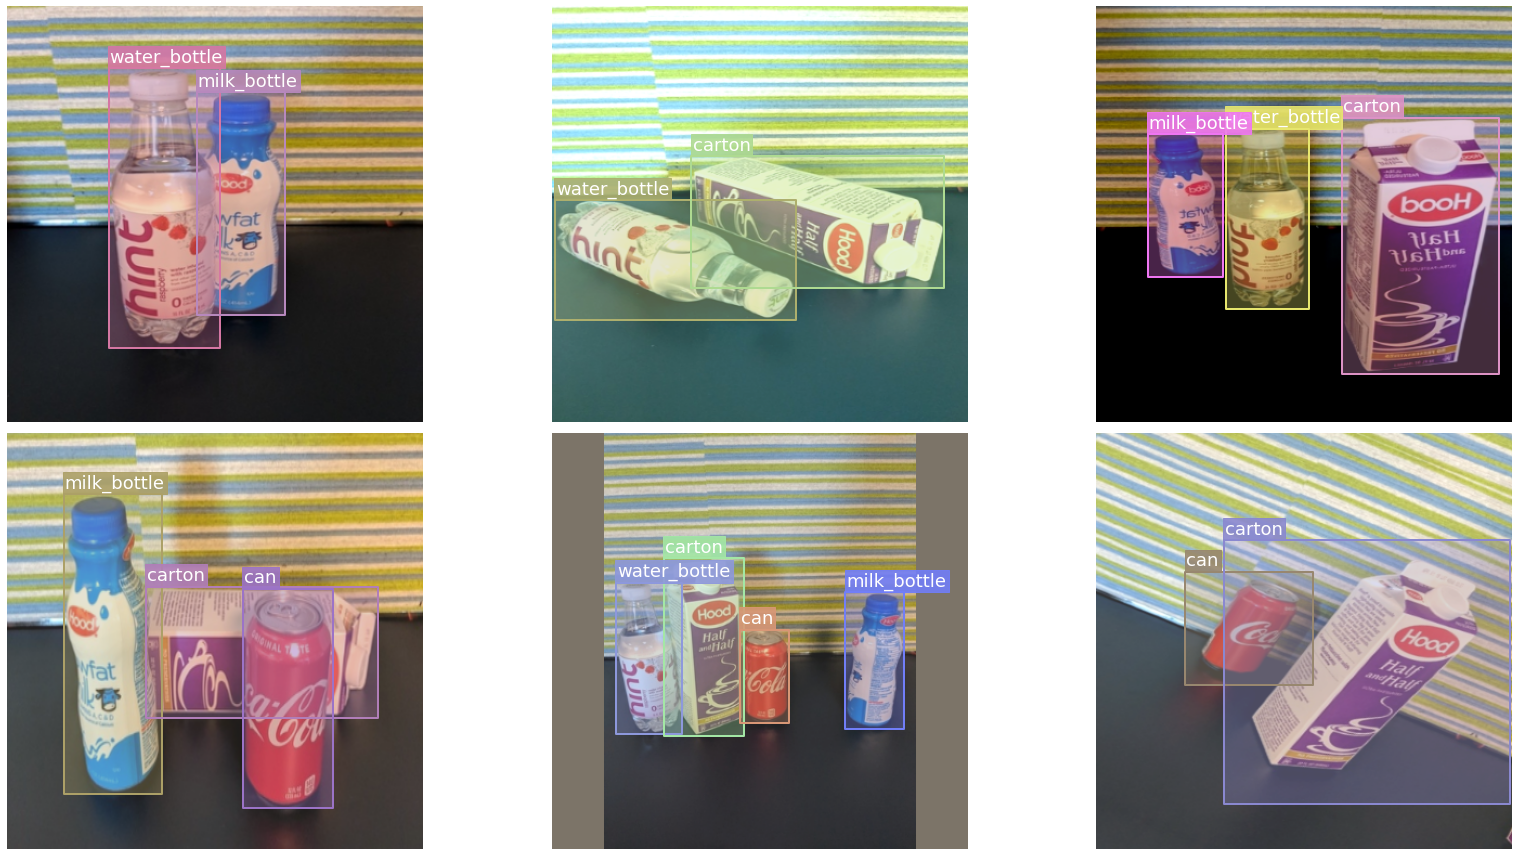

In [10]:
batch, samples = first(train_dl)
show_samples(
    samples[:6], class_map=class_map, ncols=3, denormalize_fn=denormalize_imagenet
)

## Model

In [ ]:
# Model
model = efficientdet.model(
    model_name="tf_efficientdet_lite0", num_classes=len(class_map), img_size=size
)

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai
For getting access to the helper functions to train with fastai, just `import` as follows:

In [12]:
# Fastai Learner
metrics = [COCOMetric()]
learn = efficientdet.fastai.learner(
    dls=[train_dl, valid_dl], model=model, metrics=metrics
)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

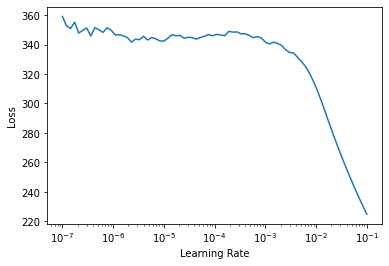

In [13]:
# Fastai Training
learn.freeze()
learn.lr_find()

In [ ]:
learn.fine_tune(50, 1e-2, freeze_epochs=20)

## Inference


### 11.4- Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient. 

In [ ]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=8)
samples, preds = efficientdet.predict_from_dl(model, infer_dl)

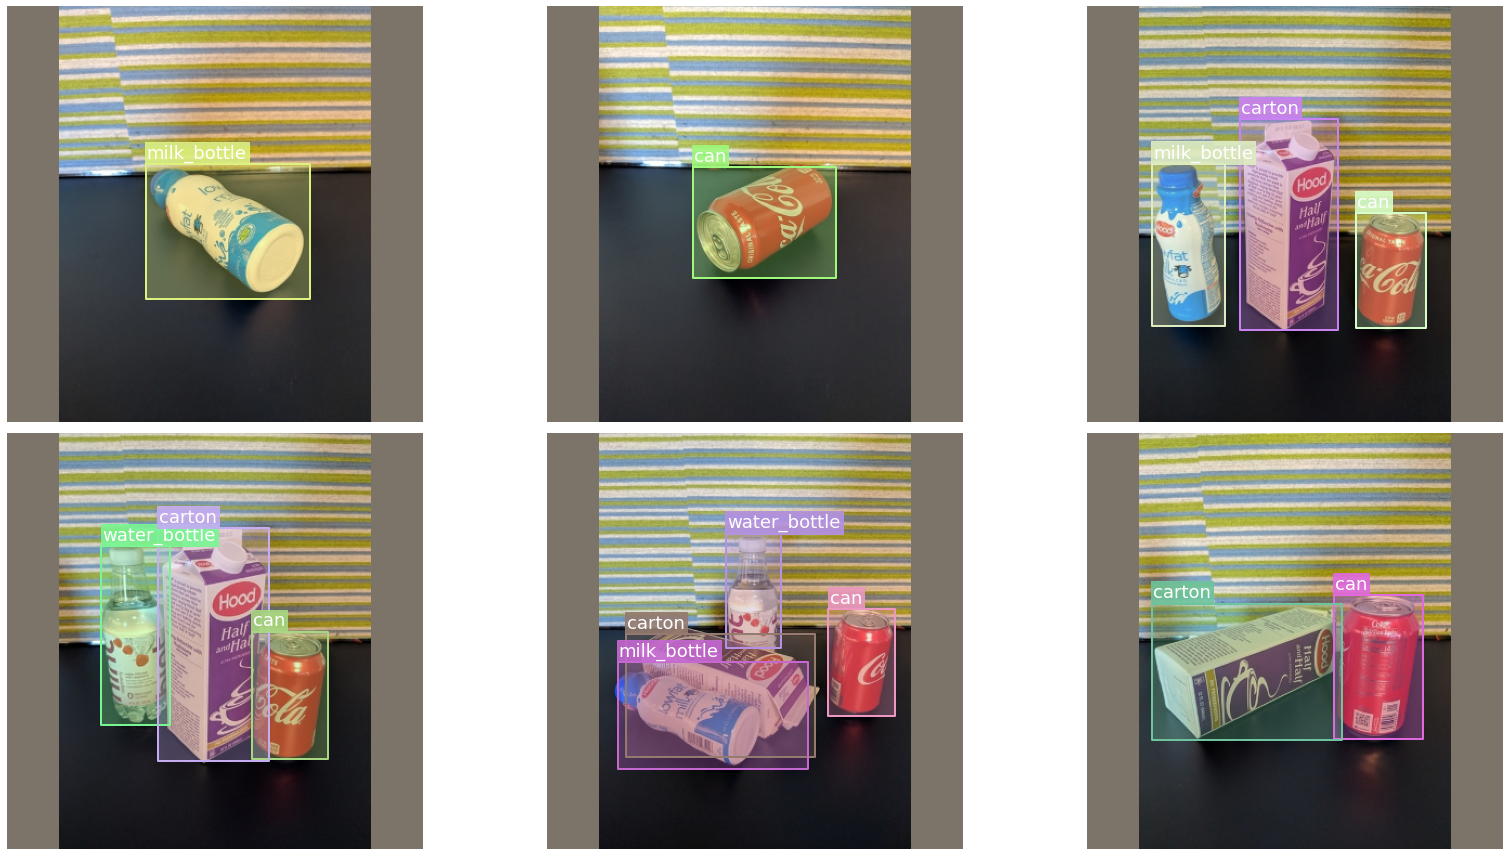

In [22]:
# Show samples
imgs = [sample["img"] for sample in samples]
show_preds(
    imgs=imgs[:6],
    preds=preds[:6],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

## Saving Model on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

In [25]:
torch.save(model.state_dict(), root_dir/'icevision/models/fridge/fridge_tf_efficientdet_lite0.pth')

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://spectrum.chat/mantis).